In [1314]:
import cv2
import os
import re
import numpy as np
import tifffile
from matplotlib import pyplot as plt

In [1315]:
#setup variables
color_channel = 3 #1,2,3

var_kernel_row = 1 #1 was good
var_kernel_col = 1 #1 was good
cstacks_blur_kernel = (9,9) #was using 3,3 before with ok results. 7,7 seems to blend away the halo a bit
pixel_offset = 1 #don't need an offset anymore since figuring out the float problem
blur_sd = 5 #3was good so was 1, maybe 1 best, went to 5 with a 5,5 blur kernel and saw no diff.

In [1316]:
# 20210119-015407_FF_20X_LATE_JLV_TOP_00012_W

path = "/Users/wesleywong/single-field-zstack copy merge/20X_CD451_CC3_3X5_STD/" #i need this
fins = "/Users/wesleywong/single-field-zstack copy merge/20X_CD451_CC3_3X5_STD/" #and this
fins = os.listdir(fins)

only_tifs = re.compile(r'.*CH.[.]tif')

#find all the z-positions
zpos = re.compile(r'Z\d\d\d')


In [1317]:
all_tifs = []
for file in fins:
    if re.match(only_tifs,file):
        all_tifs.append(file)
    

In [1318]:
print(all_tifs[0:3])

['20X_LATE_JLV_TOP_00007_Z053_CH2.tif', '20X_LATE_JLV_TOP_00010_Z025_CH4.tif', '20X_LATE_JLV_TOP_00014_Z042_CH1.tif']


In [1319]:
unique_z_pos = []
for file in all_tifs:
    unique_z_pos.append(re.search(zpos,file).group(0))

In [1320]:
unique_z_pos = sorted(unique_z_pos)
unique_z_pos = np.unique(unique_z_pos).tolist()
print(unique_z_pos[0:3])

['Z001', 'Z002', 'Z003']


In [1321]:
test = all_tifs[0]
print(test)

20X_LATE_JLV_TOP_00007_Z053_CH2.tif


In [1322]:
image_family_name = re.compile(r'^.*\d\d\d\d\d_Z')
base_name = re.search(image_family_name, all_tifs[0]).group(0)[:-7] #without tile or z pos
print('image series root name: %s' %base_name)

image series root name: 20X_LATE_JLV_TOP_


In [1323]:
image_stack = []
ch = str(color_channel) #(1-4)
for z in unique_z_pos:
    image_stack.append(str(base_name+'00001_'+z+'_CH'+ch+'.tif'))

In [1324]:
print(image_stack[0:3])

['20X_LATE_JLV_TOP_00001_Z001_CH3.tif', '20X_LATE_JLV_TOP_00001_Z002_CH3.tif', '20X_LATE_JLV_TOP_00001_Z003_CH3.tif']


In [1325]:
image_stack_arrays = []
for image in image_stack:
    fullpath = path+image
    im = tifffile.imread(fullpath)
    try: 
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    except: 
        im = im
    image_stack_arrays.append(im)

In [1326]:
print('stack length: %d' % len(image_stack_arrays)) #image_stack_arrays is what I should try to apply the MCI functions to

stack length: 82


# start contrast calcs

In [1327]:
#FIRST PIECE OF THE PUZZLE i think the whole thing is correct
def calcContrast(image, w_x, w_y):
    image = image.astype('float')
    kernel_fill = 1/((2*w_x+2)*(2*w_y+2))
    kernel_row = np.array([kernel_fill for x in range(0,2*w_y+2)]) #this is definitely correct
    kernel = np.array([kernel_row for x in range(0,2*w_x+2)]) #this is definitely correct
    
    img_squared = np.square(image.astype('float'))
    print('img_squared: %s' % img_squared.dtype)
    
    contrast = cv2.filter2D(img_squared, -1, kernel) - np.square(cv2.filter2D(image, -1, kernel)) #neg value means result array same data depth as source

    return contrast

In [1328]:
foo = calcContrast(image_stack_arrays[0],var_kernel_row,var_kernel_col)
print(foo.shape)
print(foo.dtype)

if np.max(foo)==0:
    print('max value of mask is %d (NOT GOOD)' % np.max(foo))
else:
    print('maybe it worked')

img_squared: float64
(720, 960)
float64
maybe it worked


original:  uint8
contrast:  float64


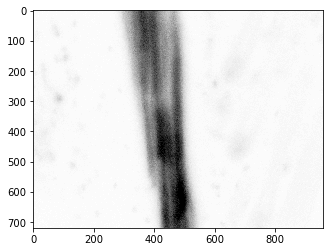

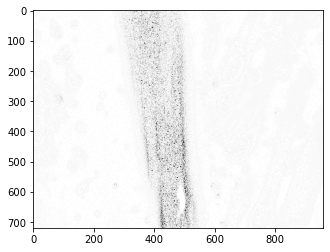

In [1331]:
from matplotlib import pyplot as plt

plt.figure(1)
print('original: ',image_stack_arrays[0].dtype)
plt.imshow(image_stack_arrays[0],cmap='Greys')
plt.figure(2)
print('contrast: ',foo.dtype)
plt.imshow(foo,cmap='Greys')

Text(0.5, 1.0, 'z=80')

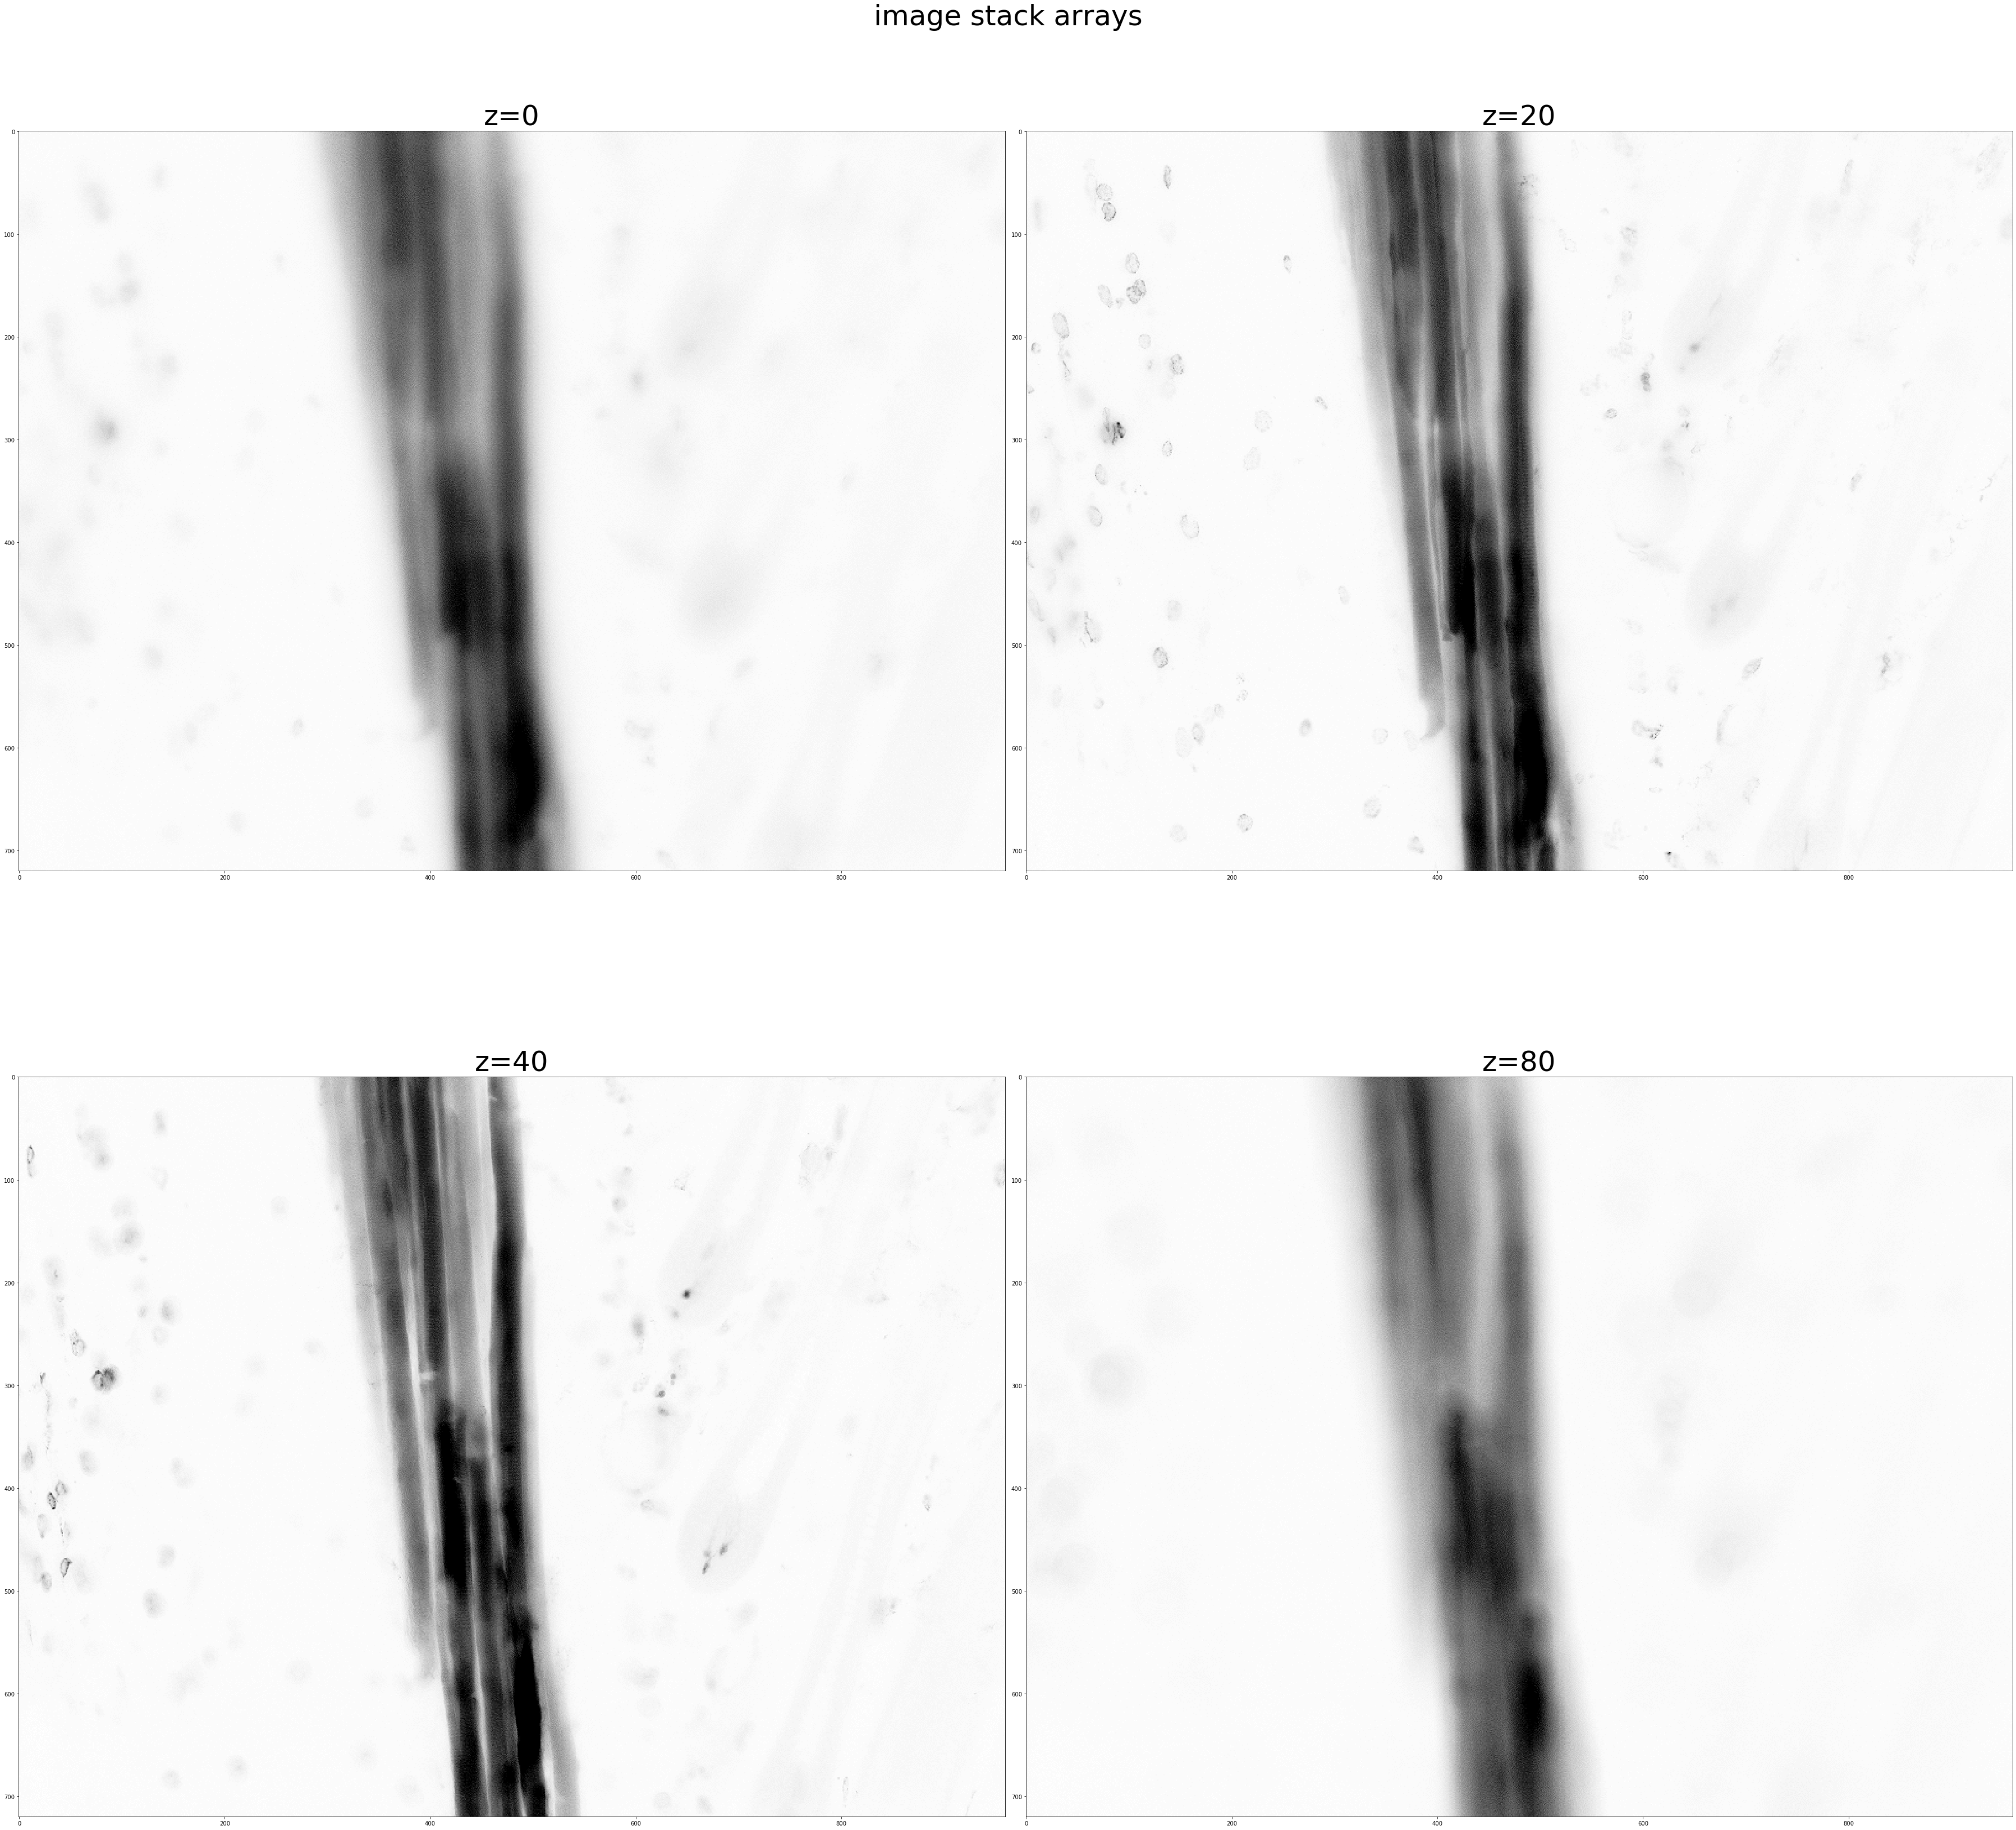

In [1332]:
fig = plt.figure(figsize=(50,50))
fig.set_tight_layout(True)
fig.suptitle('image stack arrays',fontsize=50)

ax = fig.add_subplot(2,2,1)
ax.imshow(image_stack_arrays[0],cmap='Greys')
ax.set_title('z=0',fontsize=50)
ax = fig.add_subplot(2,2,2)
ax.imshow(image_stack_arrays[20],cmap='Greys')
ax.set_title('z=20',fontsize=50)
ax = fig.add_subplot(2,2,3)
ax.imshow(image_stack_arrays[40],cmap='Greys')
ax.set_title('z=40',fontsize=50)
ax = fig.add_subplot(2,2,4)
ax.imshow(image_stack_arrays[80],cmap='Greys')
ax.set_title('z=80',fontsize=50)

In [1333]:
def getContrastStack(imageStack, w_x, w_y):
    # Calculate the contrast for each image in the stack
    temp_stack = []
    #contrast_stack = lapply(img_frames, calcContrast, w_x, w_y, brushShape)
    for frame in imageStack:
        temp=calcContrast(frame, w_x, w_y)
        temp_stack.append(temp) #i just needed to combine the 3 layers somehow...
    #contrast_stack = np.dstack(temp_stack)
    contrast_stack = temp_stack
    return contrast_stack #single channel MCP

In [1334]:
cstacks = getContrastStack(image_stack_arrays, var_kernel_row, var_kernel_col)
print(cstacks[0].dtype)

img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: float64
img_squared: 

In [1335]:
########comment out if shit breaks

f_cstacks = []
for each_cstack in cstacks:
    foo = np.array(list(map(lambda x: x < np.max(x)*pixel_offset,each_cstack)))
    blurred = cv2.GaussianBlur(foo*each_cstack,cstacks_blur_kernel,sigmaX=blur_sd)
    f_cstacks.append(blurred)
    
cstacks = f_cstacks
print(cstacks[0].dtype)

float64


(720, 960) 82


Text(0.5, 1.0, 'z=80')

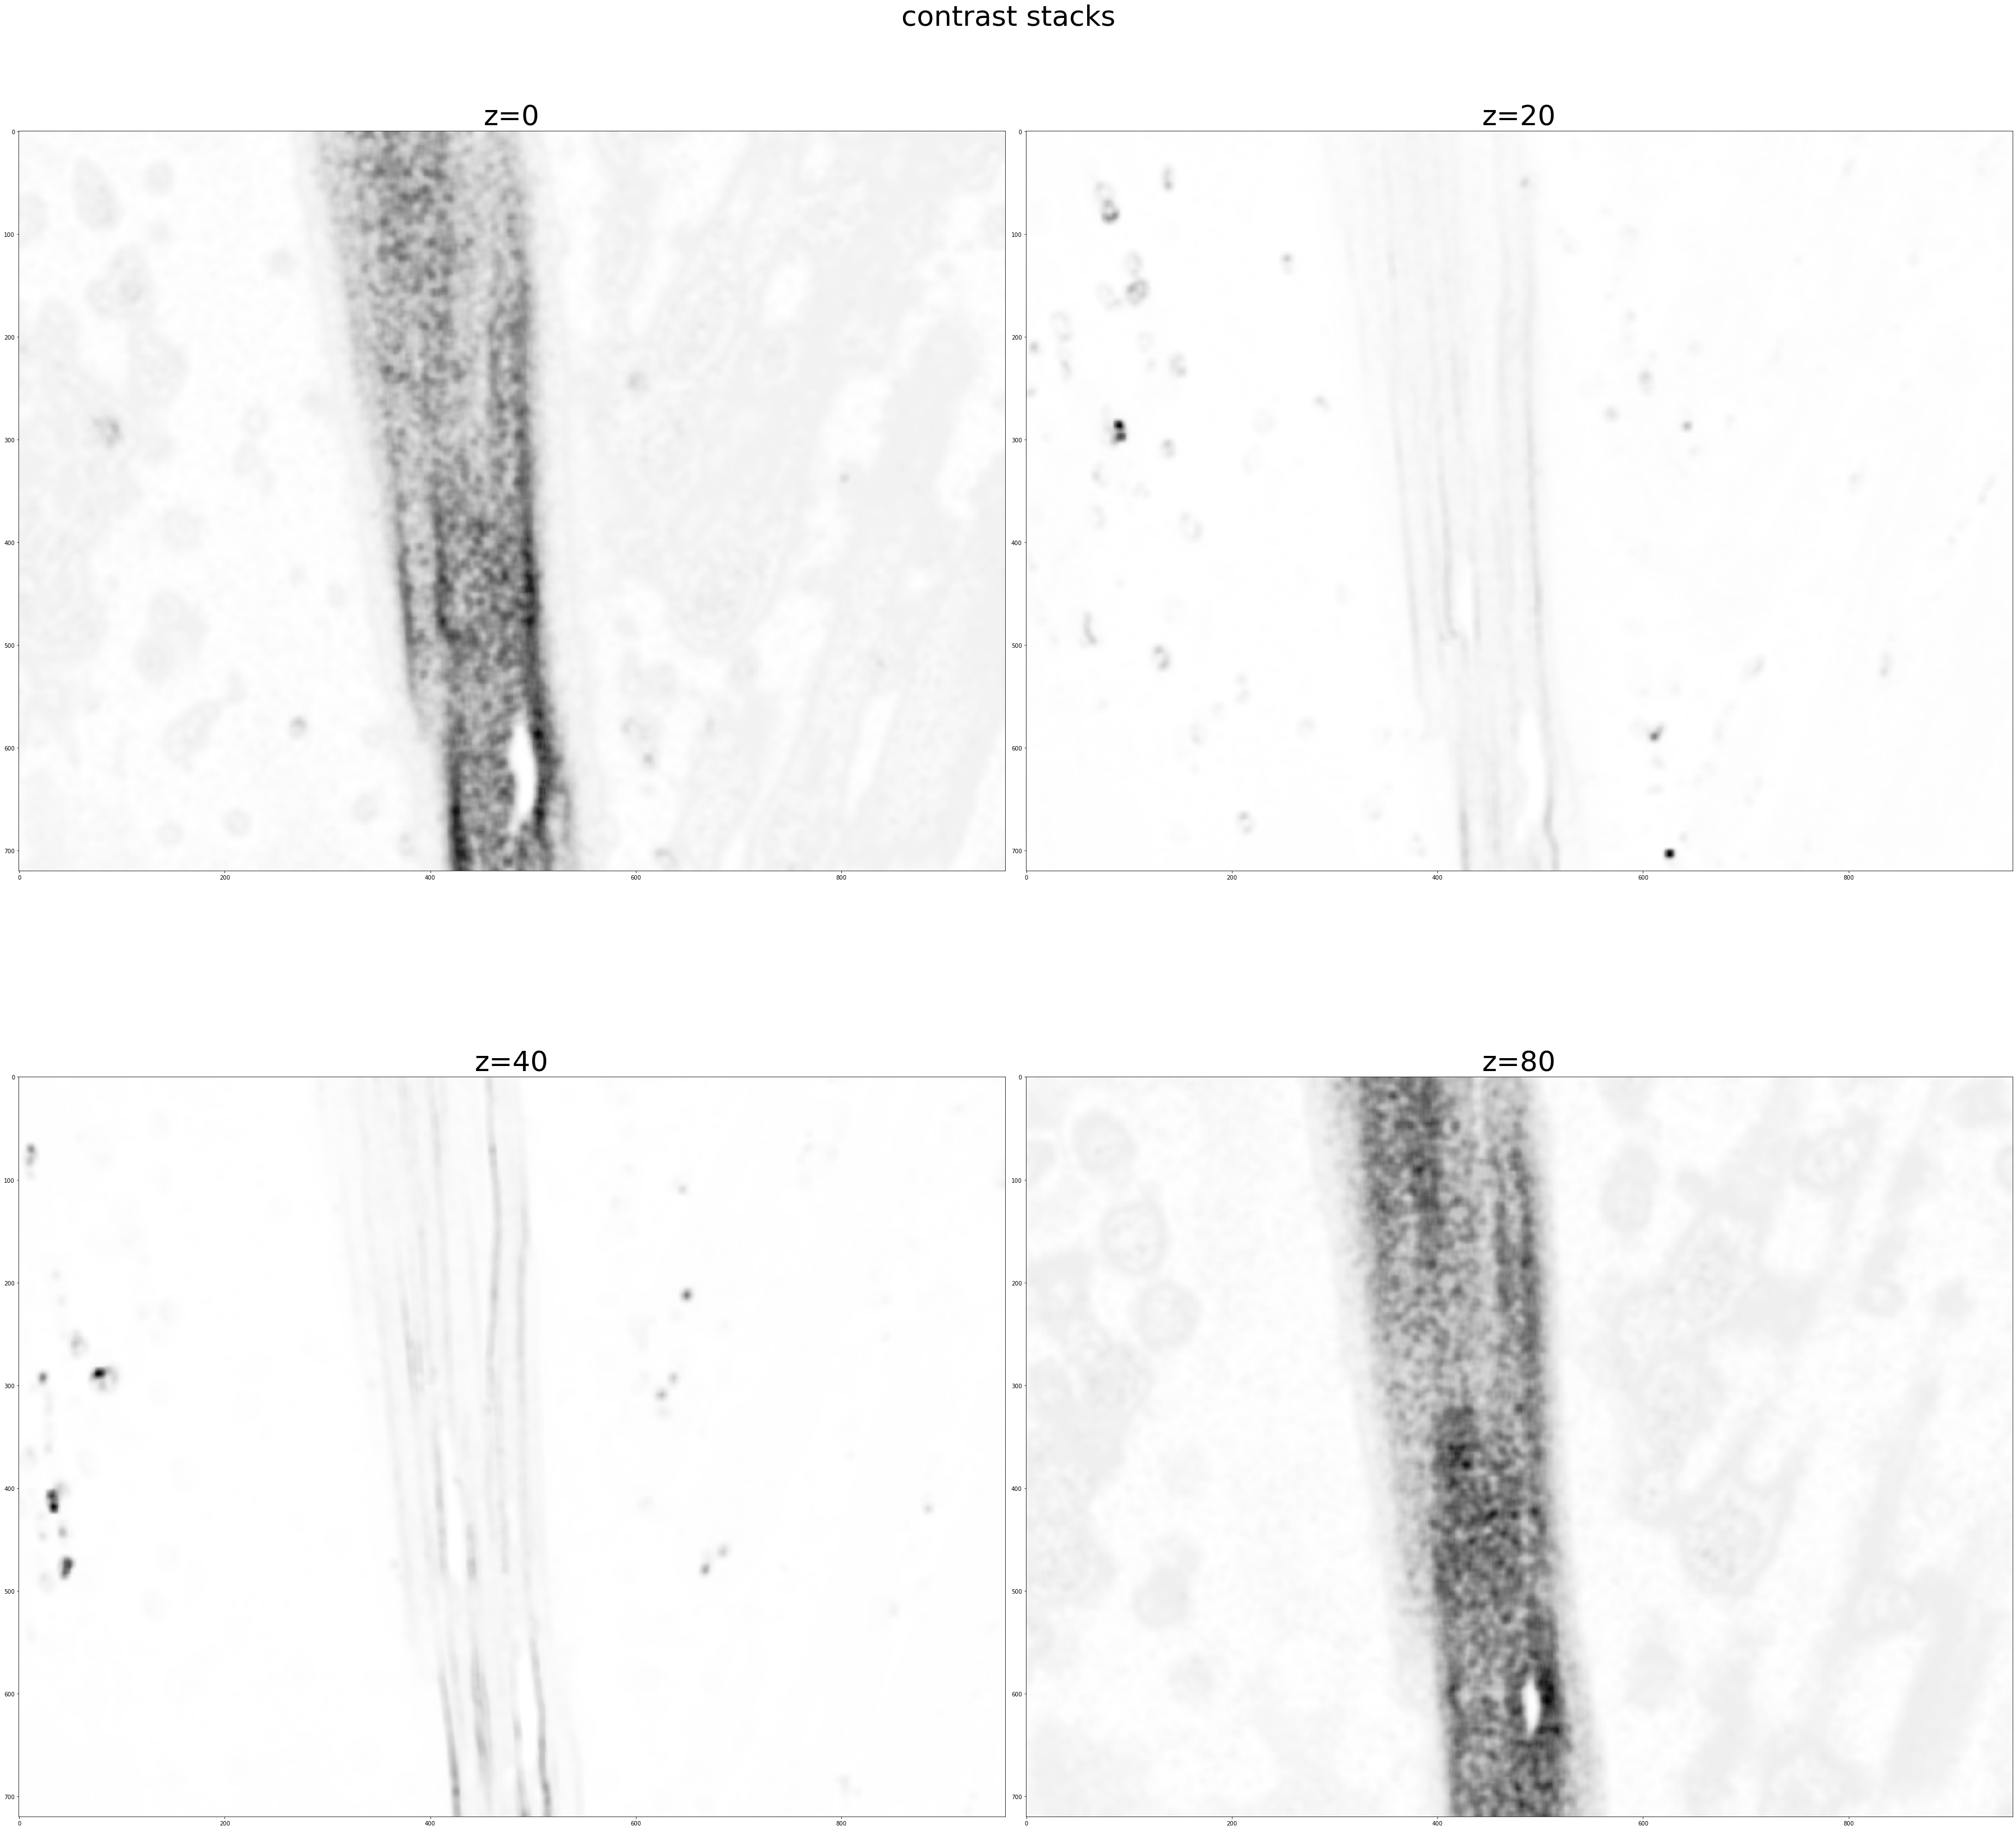

In [1336]:
print(cstacks[0].shape,len(cstacks))

fig = plt.figure(figsize=(50,50))
fig.set_tight_layout(True)
fig.suptitle('contrast stacks',fontsize=50)
ax = fig.add_subplot(2,2,1)
ax.imshow(cstacks[0],cmap='Greys')
ax.set_title('z=0',fontsize=50)
ax = fig.add_subplot(2,2,2)
ax.imshow(cstacks[20],cmap='Greys')
ax.set_title('z=20',fontsize=50)
ax = fig.add_subplot(2,2,3)
ax.imshow(cstacks[40],cmap='Greys')
ax.set_title('z=40',fontsize=50)
ax = fig.add_subplot(2,2,4)
ax.imshow(cstacks[80],cmap='Greys')
ax.set_title('z=80',fontsize=50)

float64


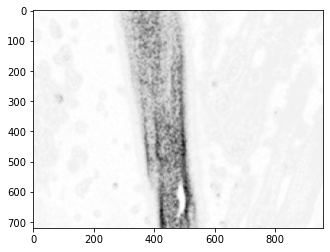

In [1338]:
foo = np.array(cstacks) #turn contrast stacks into an array and sort along z at each element for highest layer index
foo.shape
print(foo.dtype)
plt.imshow(foo[0,:,:],cmap='Greys')

In [1300]:
bar = np.argmax(foo,axis=0) #single layer in shape of single input image with elements representing best z layer index
print(bar.shape)
print(bar.dtype, bar.max())
#bar = (bar//255).astype('uint8')
print(bar.dtype) #it doesn't matter that this is int64 since it's limited to the number of z layers

(720, 960)
int64 81
int64


int64


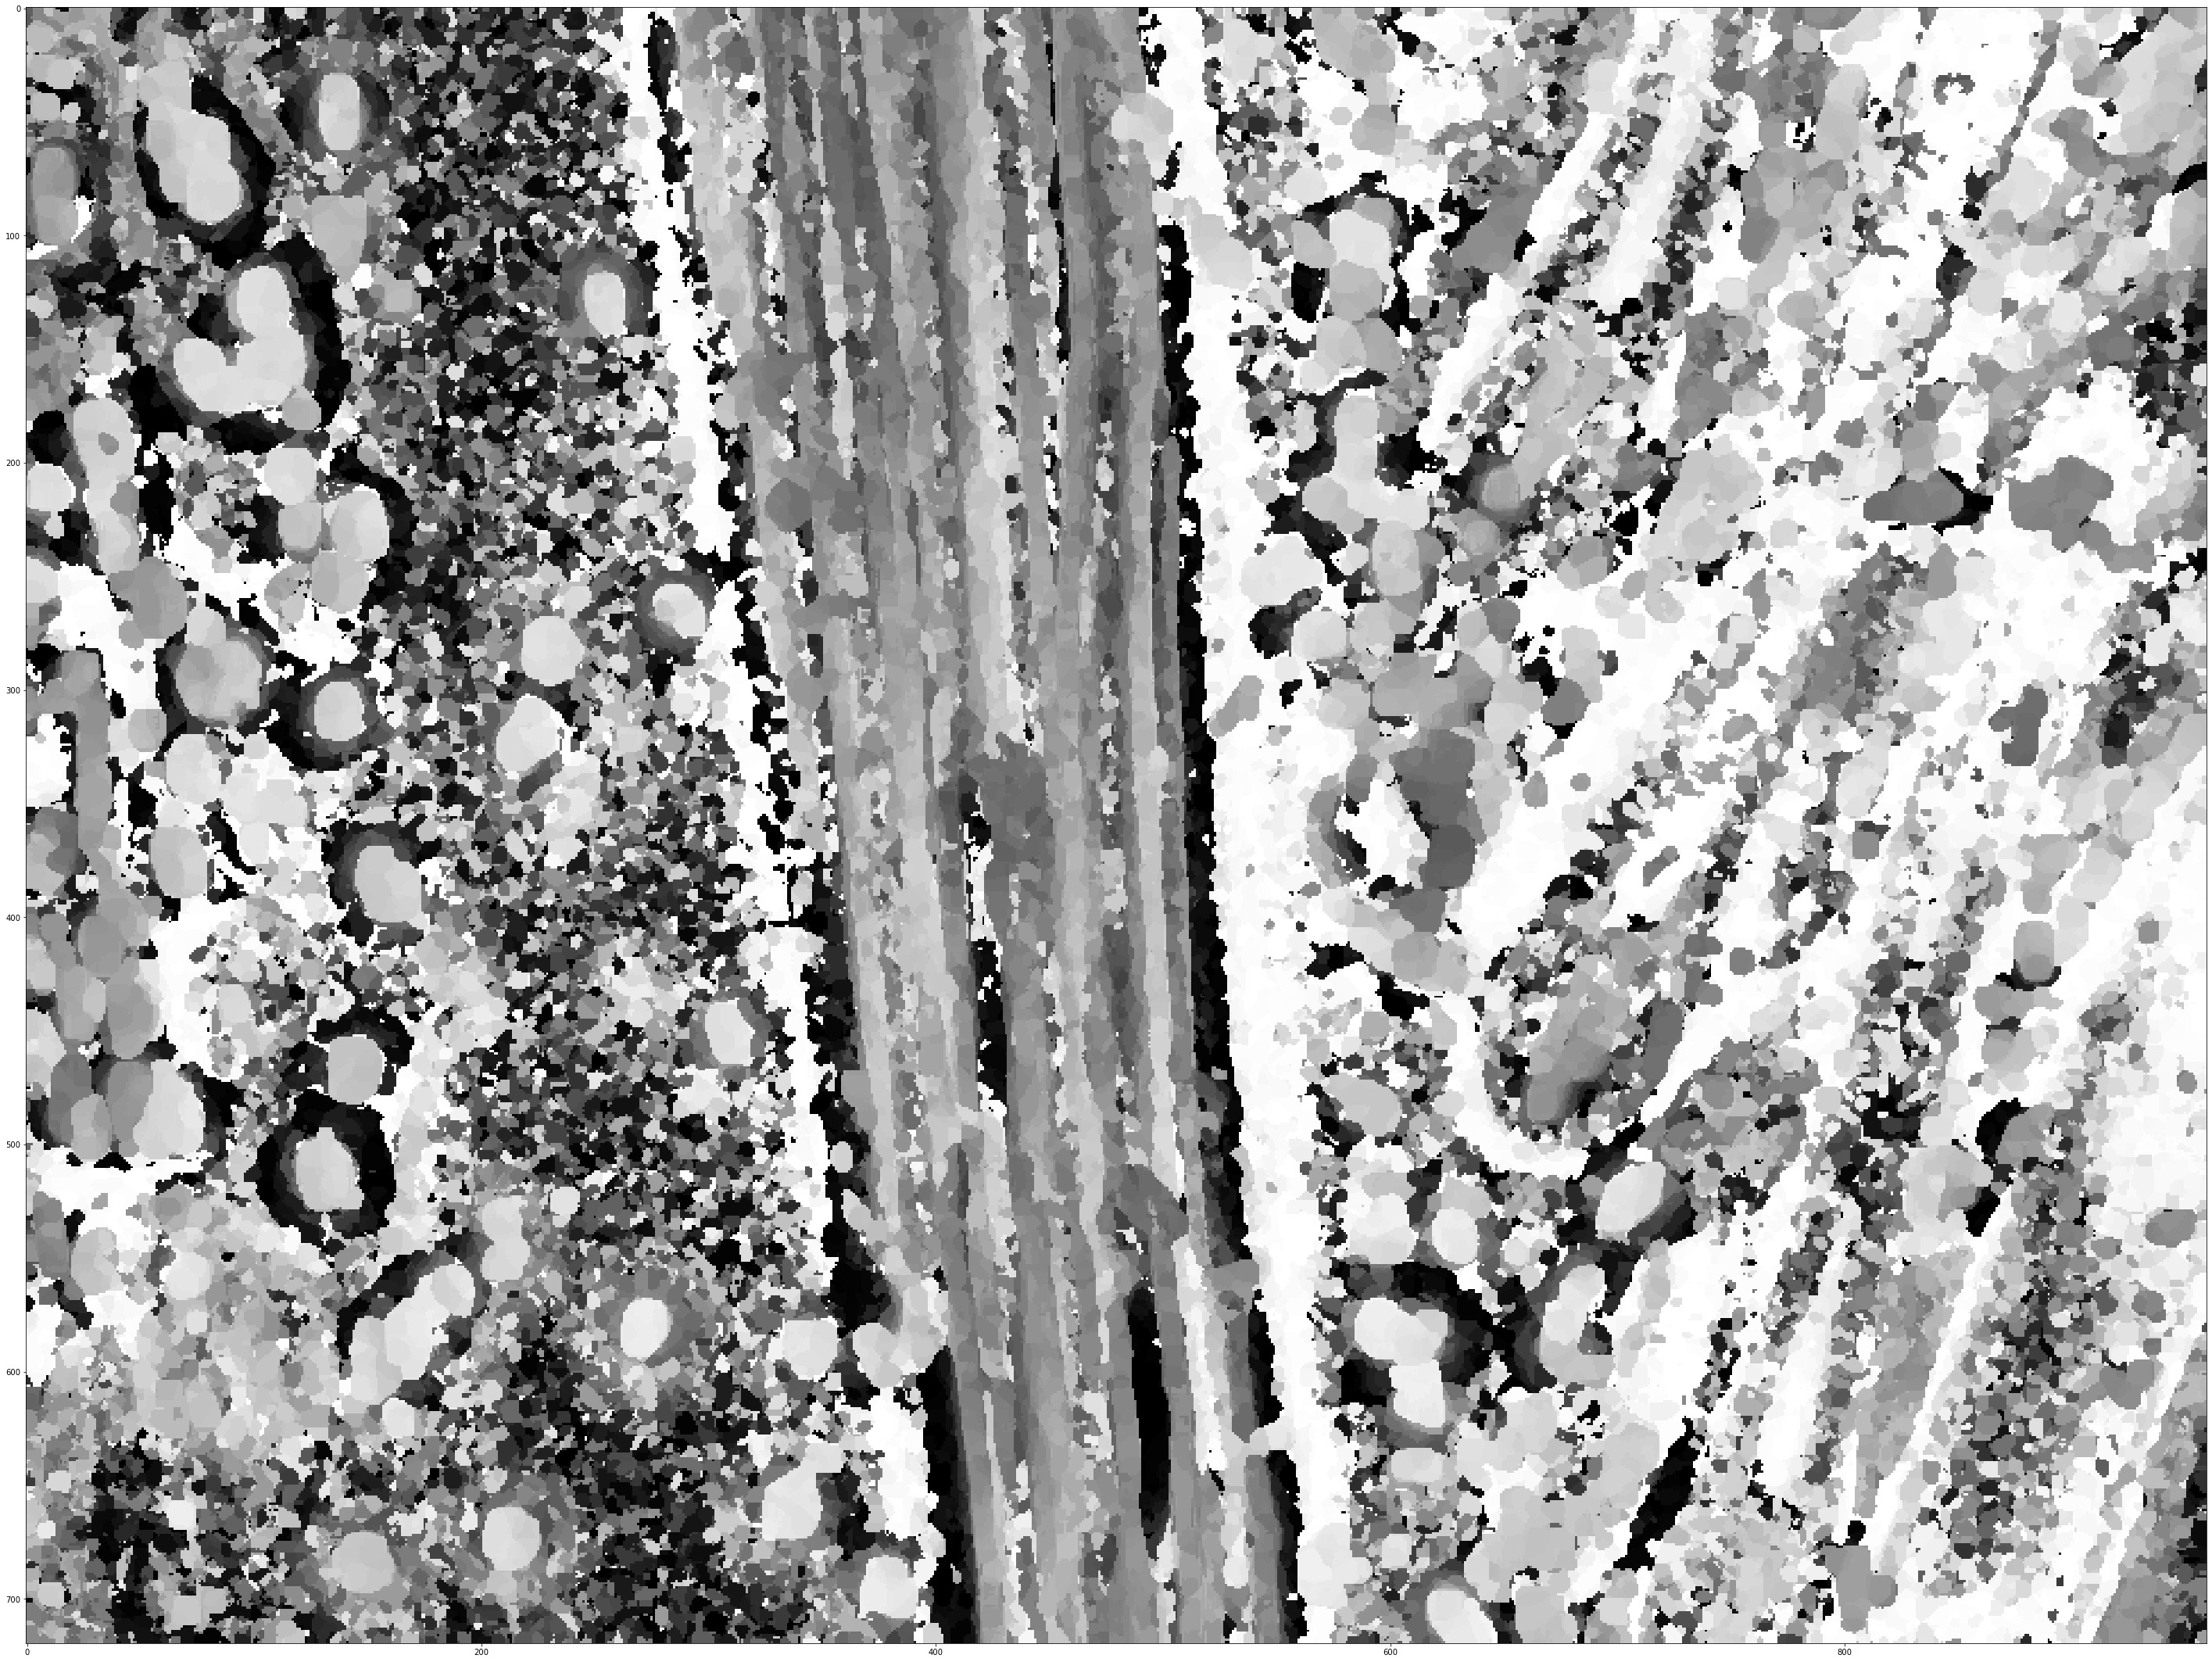

In [1339]:
plt.figure(figsize=(50,50))
plt.imshow(bar,cmap='Greys')
#tifffile.imwrite(str("/Users/wesleywong/max-contrast/art1.tif"),np.uint8(bar))
print(bar.dtype)

In [1302]:
proj = np.full(bar.shape, 0)
for row in range(bar.shape[0]):
    for col in range(bar.shape[1]):
        proj[row,col] = image_stack_arrays[bar[row,col]][row,col]
print(proj.dtype,proj.max())
proj=np.uint8(proj)

int64 29


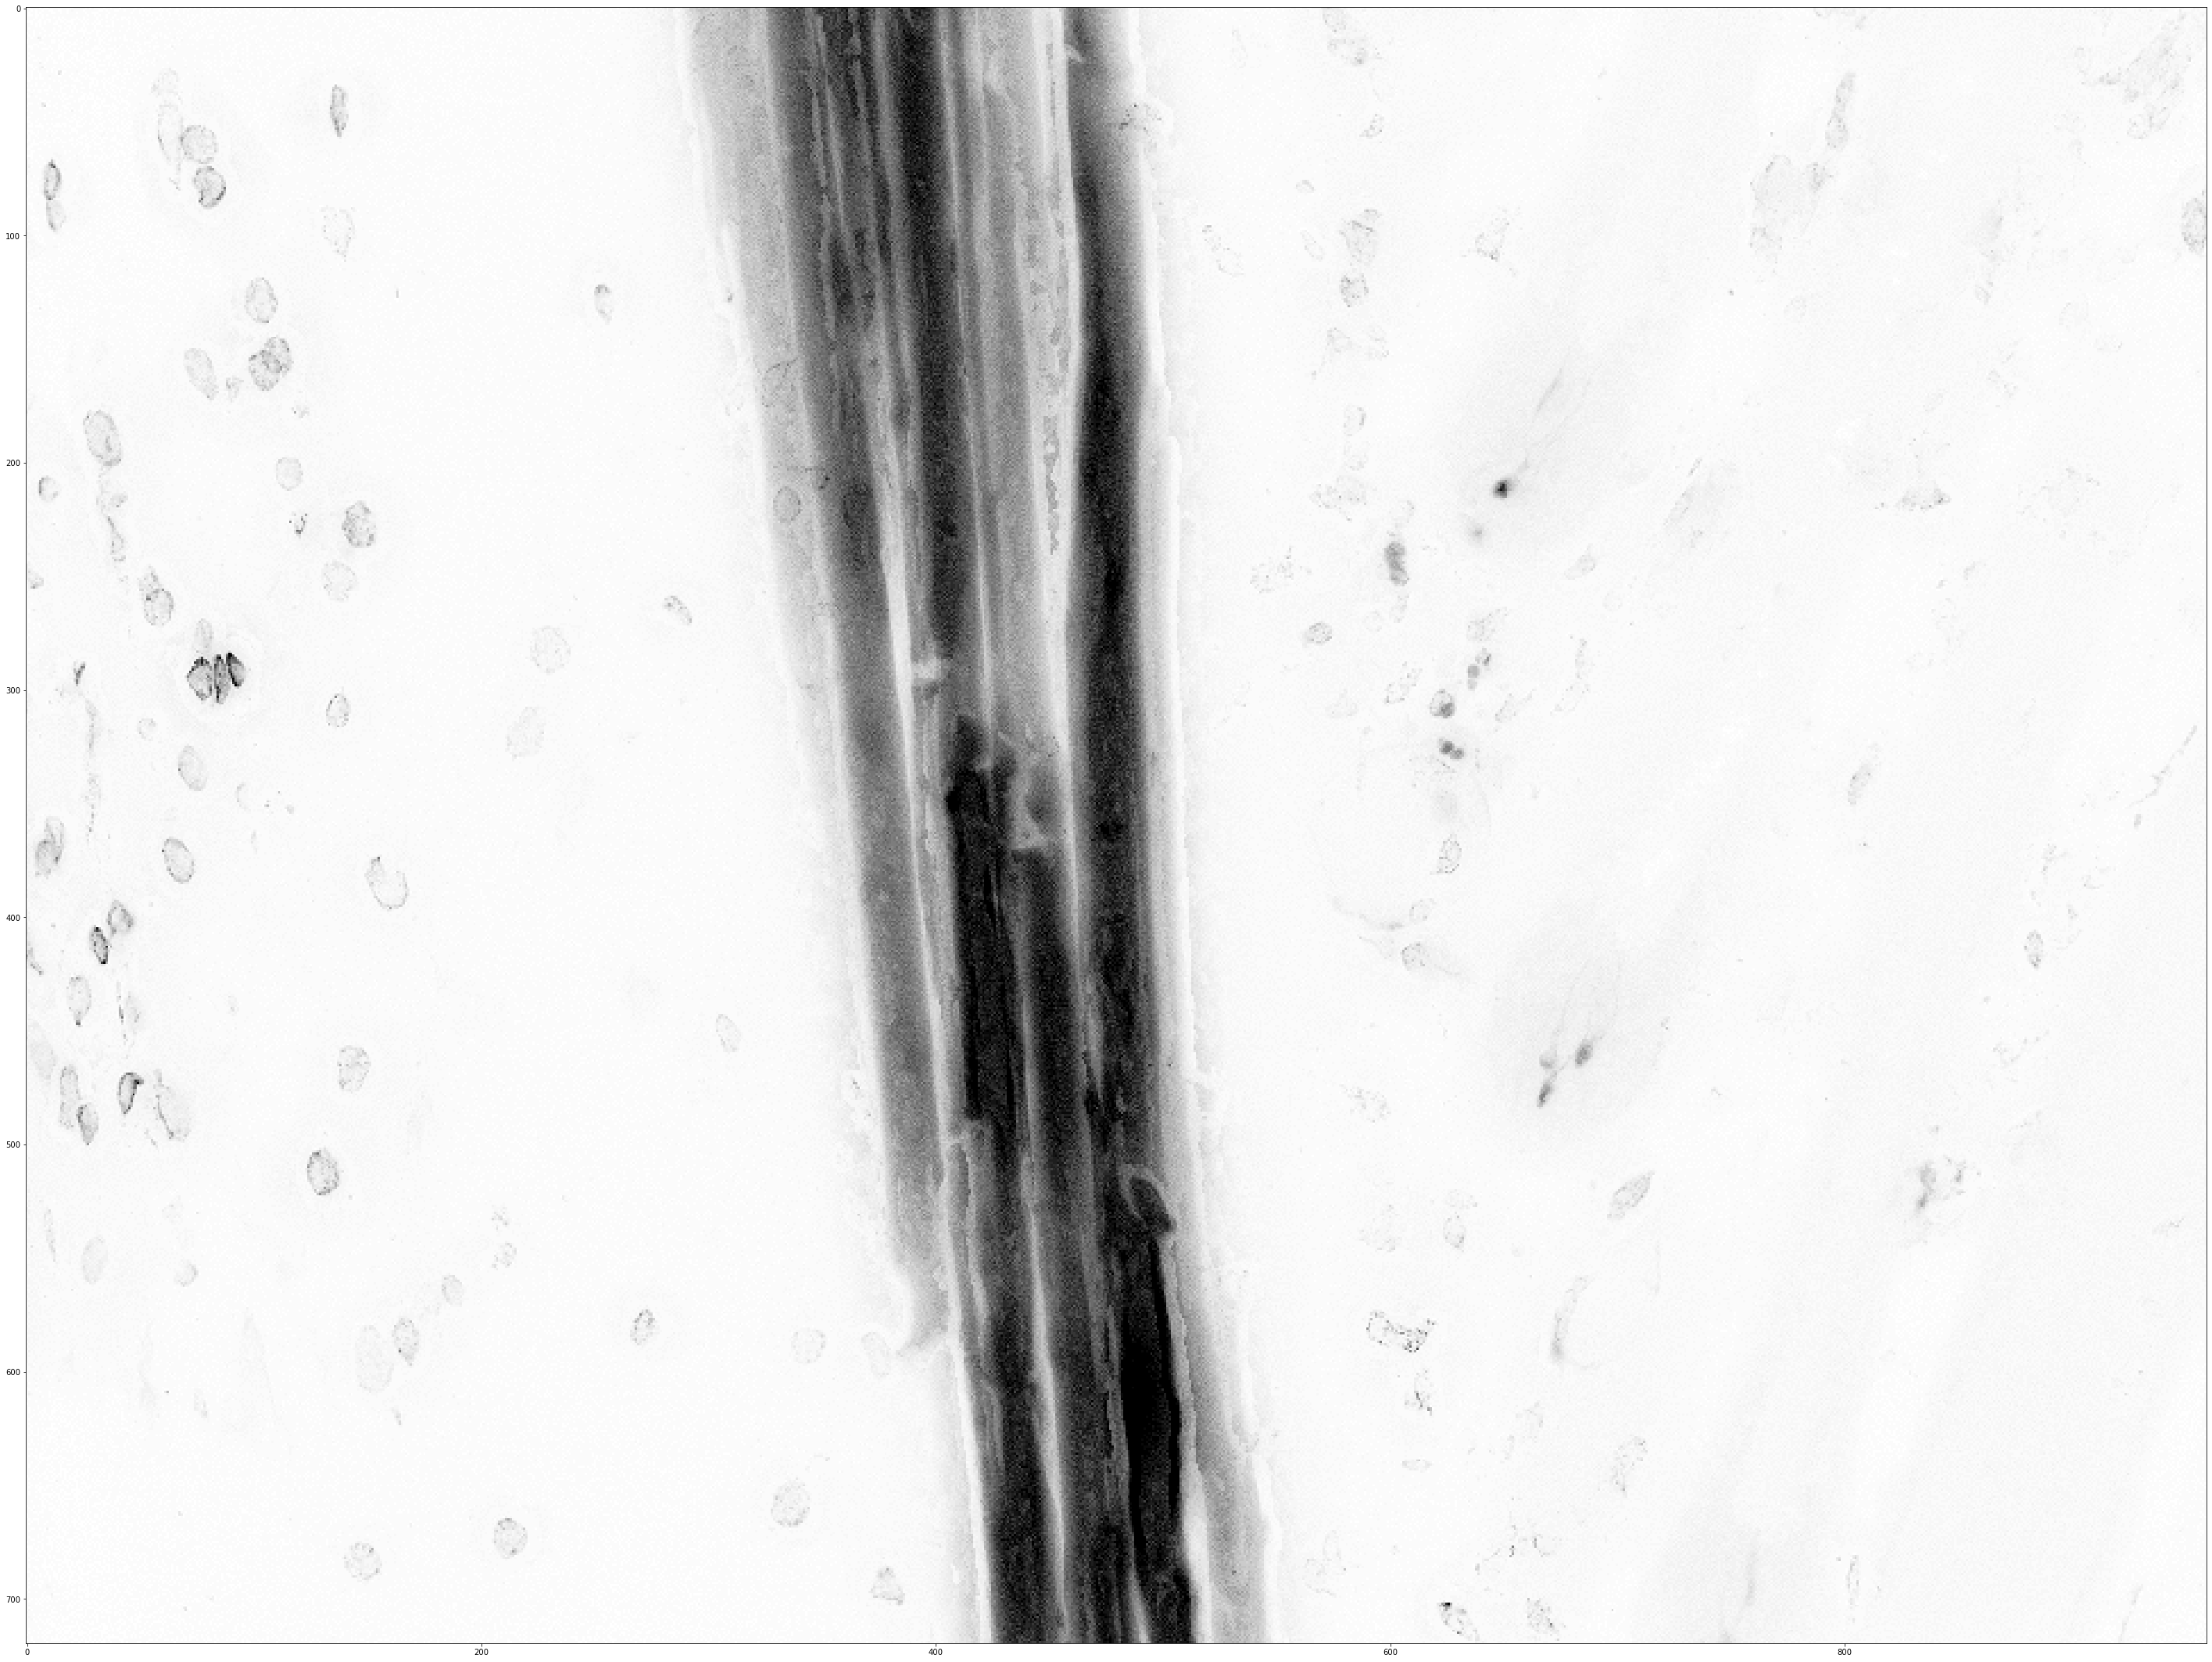

In [1340]:
plt.figure(figsize=(50,50))
plt.imshow(proj,cmap='Greys') #max contrast projection?????
tifffile.imwrite(str("/Users/wesleywong/max-contrast/K%s_S%s_output.tif" % (str((var_kernel_row,var_kernel_col)), str(cstacks_blur_kernel))),proj)


(720, 960)


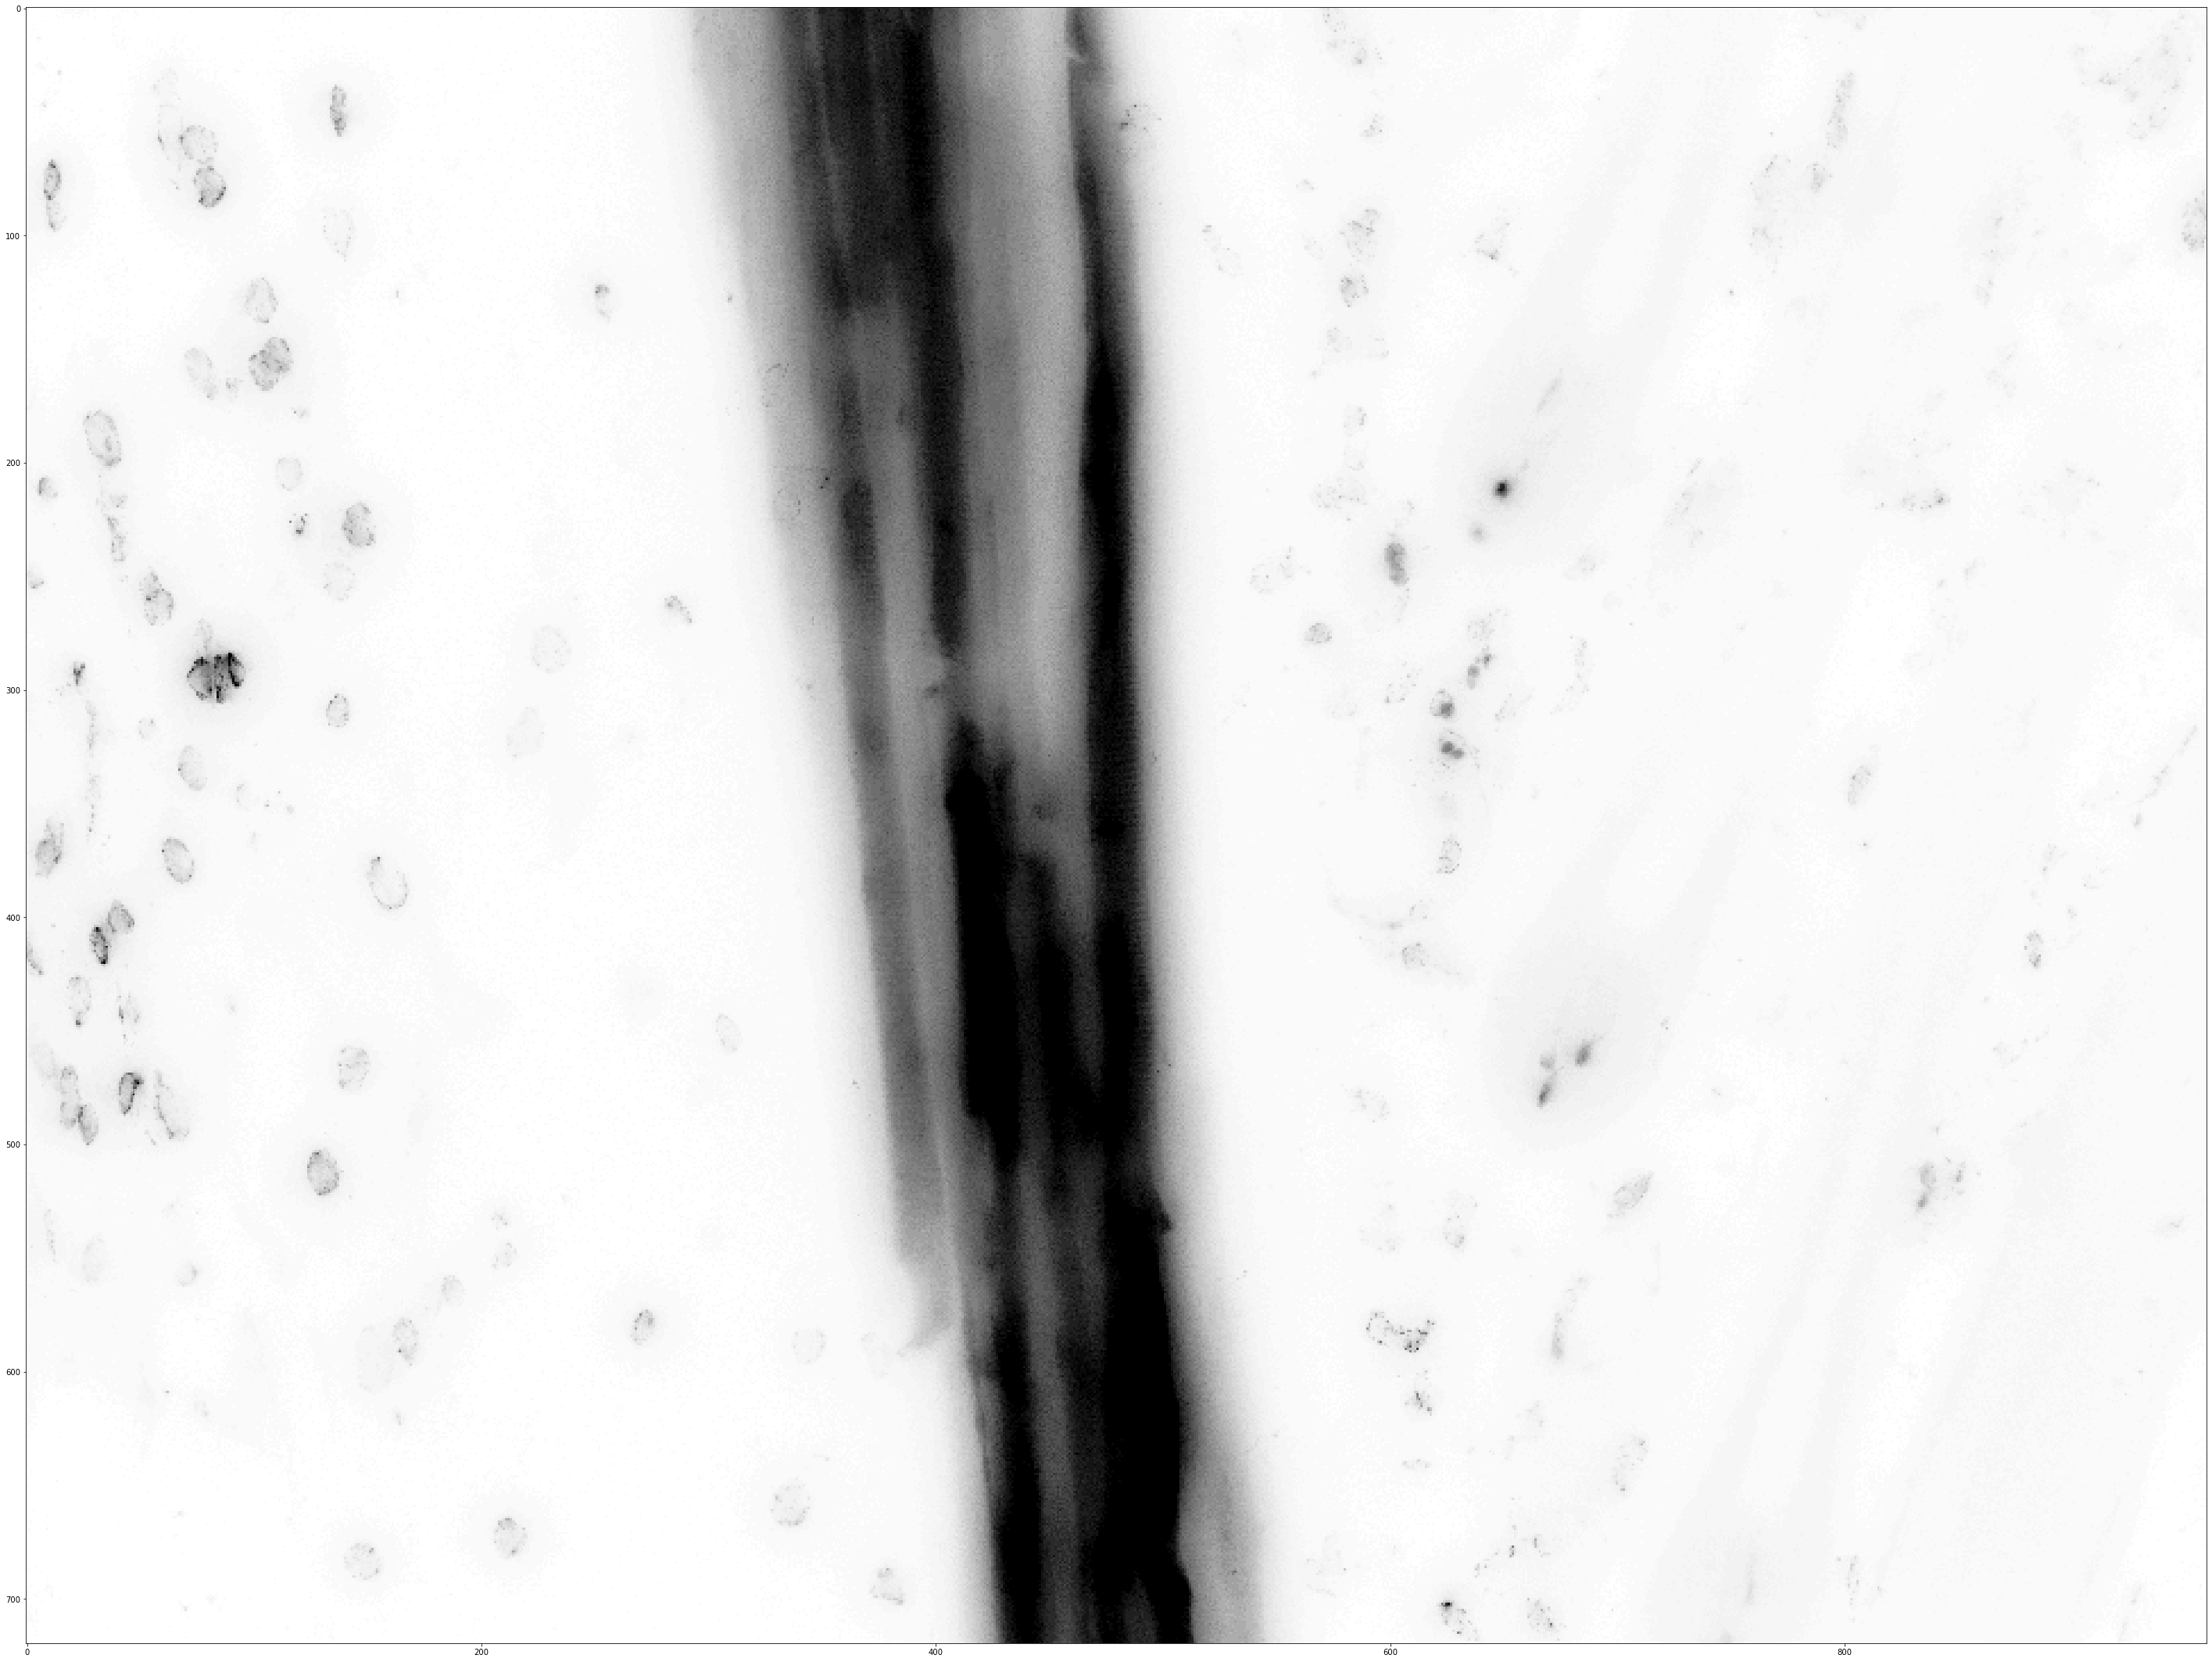

In [1341]:
plt.figure(figsize=(50,50))
intensity_projected = np.max(image_stack_arrays,axis=0)
print(intensity_projected.shape)
plt.imshow(intensity_projected,cmap='Greys') #the original
